In [21]:
import pandas as pd
import numpy as np
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
import statsmodels.tools.eval_measures as em
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import yfinance as yf
from statsmodels.tsa.stattools import grangercausalitytests

In [22]:
tickers_list = ['^GSPC','^IRX','IBB','^VIX','PFE','JNJ','IHE']
data = yf.download(tickers_list,'2013-01-01', '2023-10-20')['Adj Close']
m_data = data.groupby(data.index.to_period('M')).first()
m_data.index = m_data.index.to_timestamp()
m_data.head

[*********************100%%**********************]  7 of 7 completed


<bound method NDFrame.head of                    IBB         IHE         JNJ        PFE        ^GSPC   ^IRX  \
Date                                                                            
2013-01-01   46.244907   73.989395   52.788979  16.662203  1462.420044  0.055   
2013-02-01   48.253132   78.585373   55.277893  17.923592  1513.170044  0.060   
2013-03-01   48.840916   79.338501   57.612949  17.767906  1518.199951  0.100   
2013-04-01   52.103077   82.002724   61.541454  18.708513  1562.170044  0.065   
2013-05-01   55.894222   83.256264   63.269093  18.747437  1582.699951  0.050   
...                ...         ...         ...        ...          ...    ...   
2023-06-01  126.605476  170.649460  153.426041  37.601078  4221.020020  5.203   
2023-07-01  126.651314  176.697098  162.172546  36.246174  4455.589844  5.145   
2023-08-01  127.889771  180.209549  167.672607  35.610001  4576.729980  5.260   
2023-09-01  129.847305  189.483200  160.479996  35.779999  4515.770020  5.268  

In [23]:
print(m_data.columns)

Index(['IBB', 'IHE', 'JNJ', 'PFE', '^GSPC', '^IRX', '^VIX'], dtype='object')


In [24]:
data = {'IBB':m_data['IBB'],'IHE':m_data['IHE'],'JNJ':m_data['JNJ'],'PFE':m_data['PFE'],'GSPC':m_data['^GSPC']}
data=pd.DataFrame(data)
print(data.tail())

# 'IRX':m_data['^IRX'],'VIX':m_data['^VIX']

                   IBB         IHE         JNJ        PFE         GSPC
Date                                                                  
2023-06-01  126.605476  170.649460  153.426041  37.601078  4221.020020
2023-07-01  126.651314  176.697098  162.172546  36.246174  4455.589844
2023-08-01  127.889771  180.209549  167.672607  35.610001  4576.729980
2023-09-01  129.847305  189.483200  160.479996  35.779999  4515.770020
2023-10-01  120.639999  175.970001  155.149994  33.939999  4288.390137


In [25]:
def Log_diff(x):
    x_diff = 100 * np.log(x/x.shift(1))
    return x_diff

In [26]:
data = Log_diff(data)

In [27]:
data['IRX'] = m_data['^IRX']
data['VIX'] = m_data['^VIX']

In [28]:
data.shape

(130, 7)

In [29]:
data.head

<bound method NDFrame.head of                  IBB       IHE       JNJ       PFE      GSPC    IRX        VIX
Date                                                                          
2013-01-01       NaN       NaN       NaN       NaN       NaN  0.055  14.680000
2013-02-01  4.250939  6.026381  4.607064  7.297496  3.411419  0.060  12.900000
2013-03-01  1.210766  0.953793  4.137429 -0.872401  0.331857  0.100  15.360000
2013-04-01  6.465561  3.302894  6.596364  5.158487  2.855052  0.065  13.580000
2013-05-01  7.023701  1.517090  2.768594  0.207835  1.305631  0.050  14.490000
...              ...       ...       ...       ...       ...    ...        ...
2023-06-01 -3.693662 -6.026915 -4.945482 -2.005683  1.267167  5.203  15.650000
2023-07-01  0.036198  3.482544  5.544224 -3.669889  5.408264  5.145  13.570000
2023-08-01  0.973098  1.968338  3.335244 -1.770731  2.682531  5.260  13.930000
2023-09-01  1.519046  5.018003 -4.384402  0.476253 -1.340905  5.268  13.090000
2023-10-01 -7.354829 -

In [30]:
data = data.head(128)

In [31]:
data.head

<bound method NDFrame.head of                  IBB       IHE       JNJ       PFE      GSPC    IRX        VIX
Date                                                                          
2013-01-01       NaN       NaN       NaN       NaN       NaN  0.055  14.680000
2013-02-01  4.250939  6.026381  4.607064  7.297496  3.411419  0.060  12.900000
2013-03-01  1.210766  0.953793  4.137429 -0.872401  0.331857  0.100  15.360000
2013-04-01  6.465561  3.302894  6.596364  5.158487  2.855052  0.065  13.580000
2013-05-01  7.023701  1.517090  2.768594  0.207835  1.305631  0.050  14.490000
...              ...       ...       ...       ...       ...    ...        ...
2023-04-01  1.379210  0.228873  2.766634  2.870298  4.287978  4.570  18.549999
2023-05-01  1.354731  3.151398  4.213444 -5.314053  1.045797  4.865  16.080000
2023-06-01 -3.693662 -6.026915 -4.945482 -2.005683  1.267167  5.203  15.650000
2023-07-01  0.036198  3.482544  5.544224 -3.669889  5.408264  5.145  13.570000
2023-08-01  0.973098  

In [32]:
ndata = pd.read_csv('/Users/wangmeiyi/Desktop/100dataset/MEDCPIM158SFRBCLE.csv', index_col = 0)
print(CPI.head)

<bound method NDFrame.head of             MEDCPIM158SFRBCLE
DATE                         
2013-01-01           2.741808
2013-02-01           2.451542
2013-03-01           1.215358
2013-04-01           2.088884
2013-05-01           1.956382
...                       ...
2023-05-01           4.655686
2023-06-01           4.355447
2023-07-01           2.283639
2023-08-01           4.027318
2023-09-01           5.626580

[129 rows x 1 columns]>


In [33]:
ndata = ndata.head(128)

In [36]:
data.columns

Index(['IBB', 'IHE', 'JNJ', 'PFE', 'GSPC', 'IRX', 'VIX'], dtype='object')

In [37]:
ndata['IBB'] = data['IBB']
ndata['IHE'] = data['IHE']
ndata['JNJ'] = data['JNJ']
ndata['PFE'] = data['PFE']
ndata['GSPC'] = data['GSPC']
ndata['IRX'] = data['IRX']
ndata['VIX'] = data['VIX']
ndata.head

<bound method NDFrame.head of             MEDCPIM158SFRBCLE       IBB       IHE       JNJ       PFE  \
DATE                                                                    
2013-01-01           2.741808       NaN       NaN       NaN       NaN   
2013-02-01           2.451542  4.250939  6.026381  4.607064  7.297496   
2013-03-01           1.215358  1.210766  0.953793  4.137429 -0.872401   
2013-04-01           2.088884  6.465561  3.302894  6.596364  5.158487   
2013-05-01           1.956382  7.023701  1.517090  2.768594  0.207835   
...                       ...       ...       ...       ...       ...   
2023-04-01           4.911595  1.379210  0.228873  2.766634  2.870298   
2023-05-01           4.655686  1.354731  3.151398  4.213444 -5.314053   
2023-06-01           4.355447 -3.693662 -6.026915 -4.945482 -2.005683   
2023-07-01           2.283639  0.036198  3.482544  5.544224 -3.669889   
2023-08-01           4.027318  0.973098  1.968338  3.335244 -1.770731   

                GSPC

In [38]:
ndata = ndata[1:]
ndata.head

<bound method NDFrame.head of             MEDCPIM158SFRBCLE       IBB       IHE       JNJ       PFE  \
DATE                                                                    
2013-02-01           2.451542  4.250939  6.026381  4.607064  7.297496   
2013-03-01           1.215358  1.210766  0.953793  4.137429 -0.872401   
2013-04-01           2.088884  6.465561  3.302894  6.596364  5.158487   
2013-05-01           1.956382  7.023701  1.517090  2.768594  0.207835   
2013-06-01           2.137250  3.591904  4.398081  1.317130 -3.230410   
...                       ...       ...       ...       ...       ...   
2023-04-01           4.911595  1.379210  0.228873  2.766634  2.870298   
2023-05-01           4.655686  1.354731  3.151398  4.213444 -5.314053   
2023-06-01           4.355447 -3.693662 -6.026915 -4.945482 -2.005683   
2023-07-01           2.283639  0.036198  3.482544  5.544224 -3.669889   
2023-08-01           4.027318  0.973098  1.968338  3.335244 -1.770731   

                GSPC

In [81]:
ndata = ndata.dropna()
ndata.shape

(127, 8)

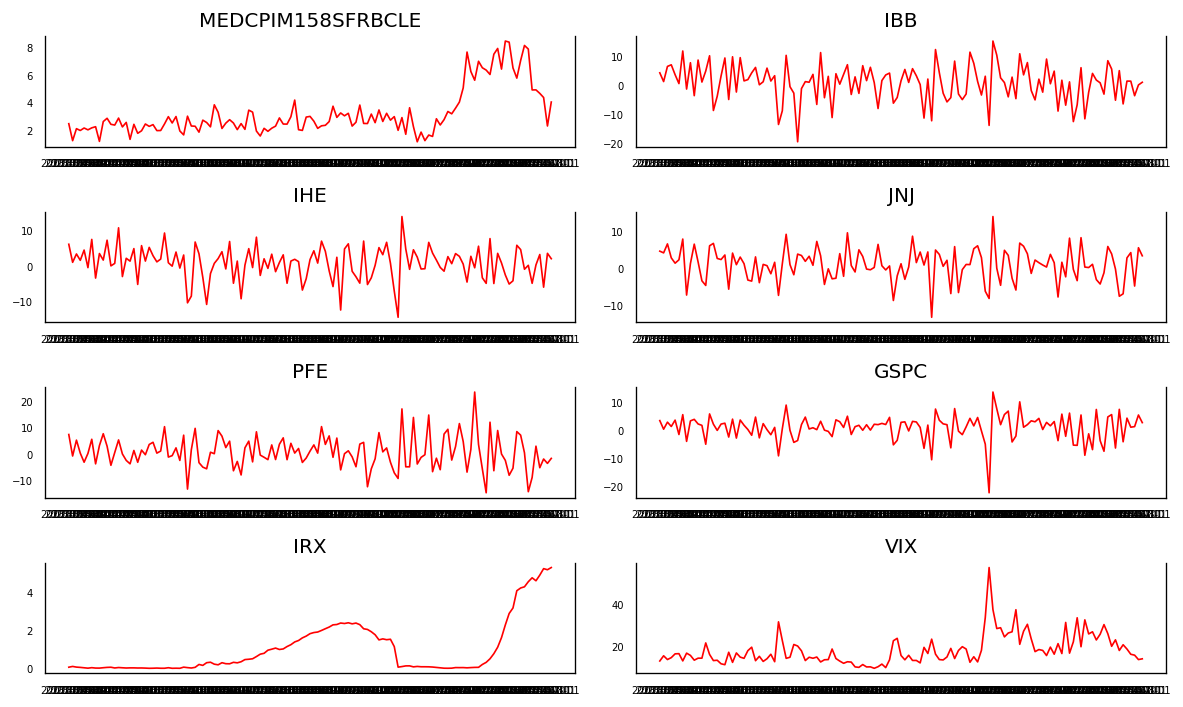

In [82]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))

for i, ax in enumerate(axes.flatten()):
    
    data1 = ndata[ndata.columns[i]]
    ax.plot(data1, color='red', linewidth=1)
    # Decorations
    ax.set_title(ndata.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [83]:
print(ndata.columns)

Index(['MEDCPIM158SFRBCLE', 'IBB', 'IHE', 'JNJ', 'PFE', 'GSPC', 'IRX', 'VIX'], dtype='object')


In [84]:
columns = ['MEDCPIM158SFRBCLE', 'IBB', 'IHE', 'JNJ', 'PFE', 'GSPC', 'IRX', 'VIX']
for column in columns:
    result = adfuller(ndata[f'{column}'])
    print(f'{column}'':')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

MEDCPIM158SFRBCLE:
ADF Statistic: -2.622688
p-value: 0.088398
IBB:
ADF Statistic: -7.674990
p-value: 0.000000
IHE:
ADF Statistic: -7.921712
p-value: 0.000000
JNJ:
ADF Statistic: -10.189430
p-value: 0.000000
PFE:
ADF Statistic: -8.355195
p-value: 0.000000
GSPC:
ADF Statistic: -9.706321
p-value: 0.000000
IRX:
ADF Statistic: -0.954135
p-value: 0.769623
VIX:
ADF Statistic: -4.029225
p-value: 0.001265


In [98]:
test_obs = 20
train = ndata[:-test_obs]
test = ndata[-test_obs:]



In [86]:
for i in [1,2,3,4,5,6,7,8,9,10]:
    model = VAR(train)
    results = model.fit(i)
    print('Order =', i)
    print('AIC: ', results.aic)
    print('BIC: ', results.bic)
    print()

Order = 1
AIC:  10.139208462733453
BIC:  11.948336904017122

Order = 2
AIC:  10.073317986641284
BIC:  13.510828535416742

Order = 3
AIC:  10.426091053630175
BIC:  15.511458167363584

Order = 4
AIC:  11.033262424727207
BIC:  17.786354200383748

Order = 5
AIC:  11.270387996984102
BIC:  19.711477043623717

Order = 6
AIC:  10.679834478288026
BIC:  20.82960915751351

Order = 7
AIC:  10.609125100937657
BIC:  22.488701149043354

Order = 8
AIC:  9.88563217435646
BIC:  23.51656472051794

Order = 9
AIC:  8.176639799598831
BIC:  23.580935794941833

Order = 10
AIC:  5.890287932652543
BIC:  23.09041900554112



/Users/wangmeiyi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/wangmeiyi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/wangmeiyi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/wangmeiyi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/wangmeiyi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency in

In [87]:
result = model.fit(6)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 24, Oct, 2023
Time:                     17:54:20
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    20.8296
Nobs:                     101.000    HQIC:                   14.7888
Log likelihood:          -1293.83    FPE:                    88662.4
AIC:                      10.6798    Det(Omega_mle):         3746.11
--------------------------------------------------------------------
Results for equation MEDCPIM158SFRBCLE
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.964902         0.921694            1.047           0.295
L1.MEDCPIM158SFRBCLE         0.453229         0.123332            3.675           0.000
L1.IBB              

In [88]:
Causality = result.test_causality(causing=['GSPC'],
                                 caused=[''],
                                 kind='wald',signif=0.1 )
print(Causality)

ValueError: '' is not in list

/Users/wangmeiyi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


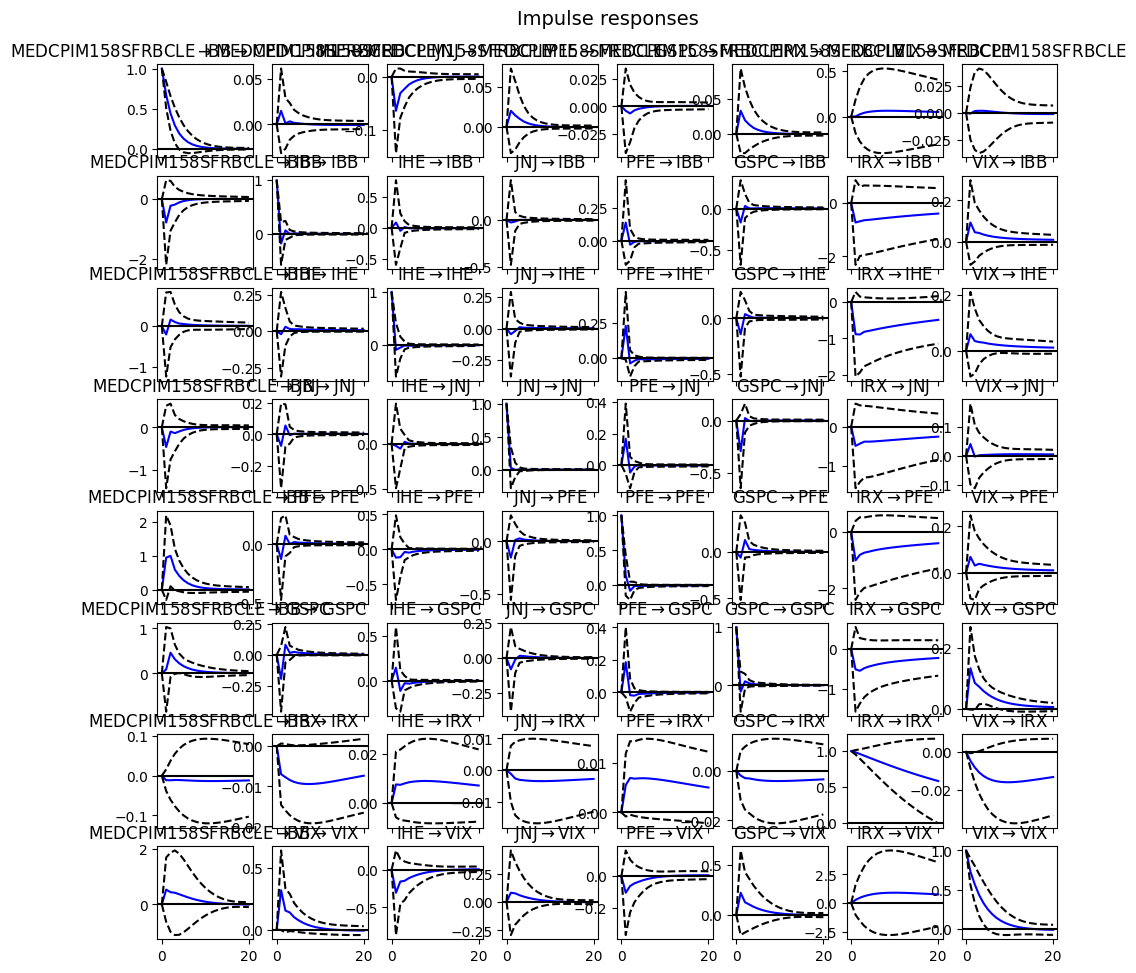

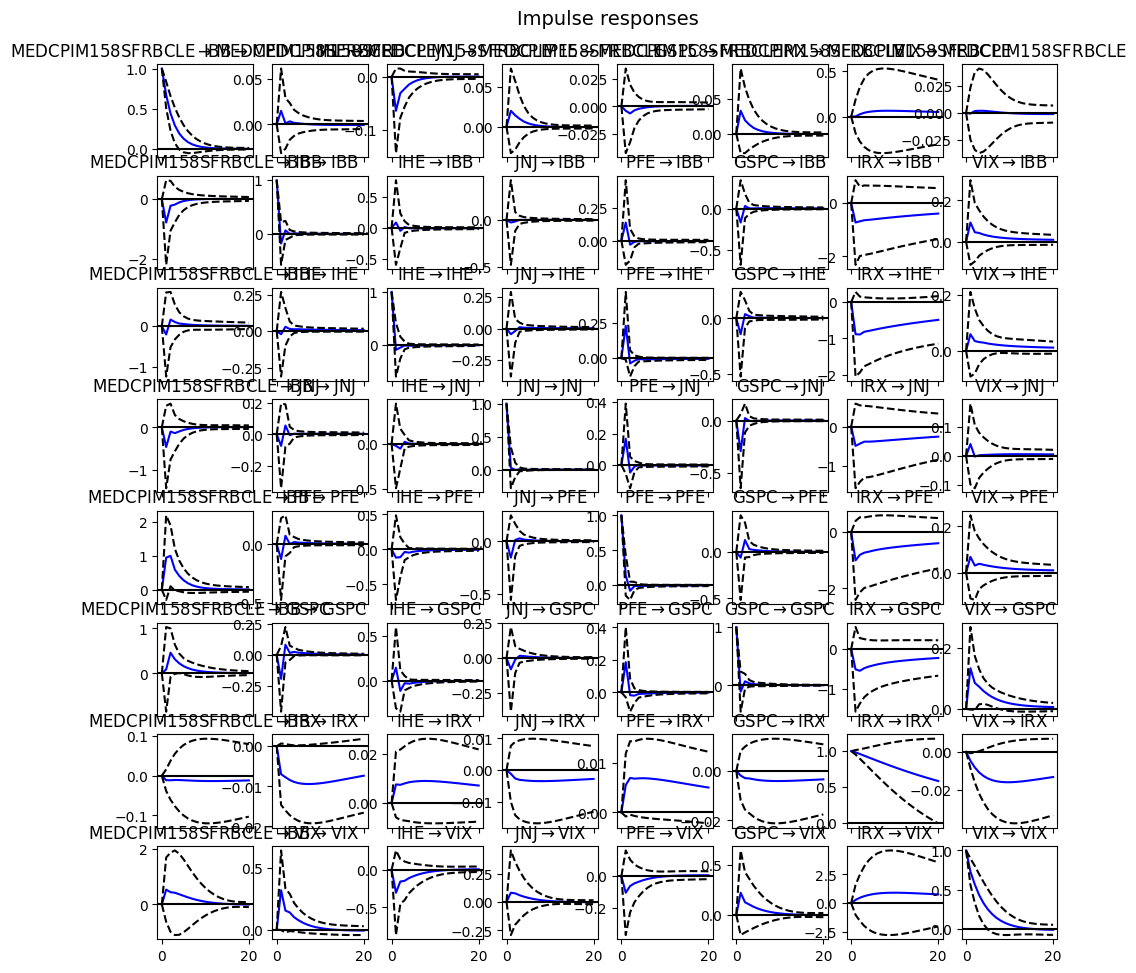

In [89]:
model = smt.VAR(train)
res = model.fit(maxlags=1)
# Impulse Response Analysis
irf = res.irf(20)
irf.plot()

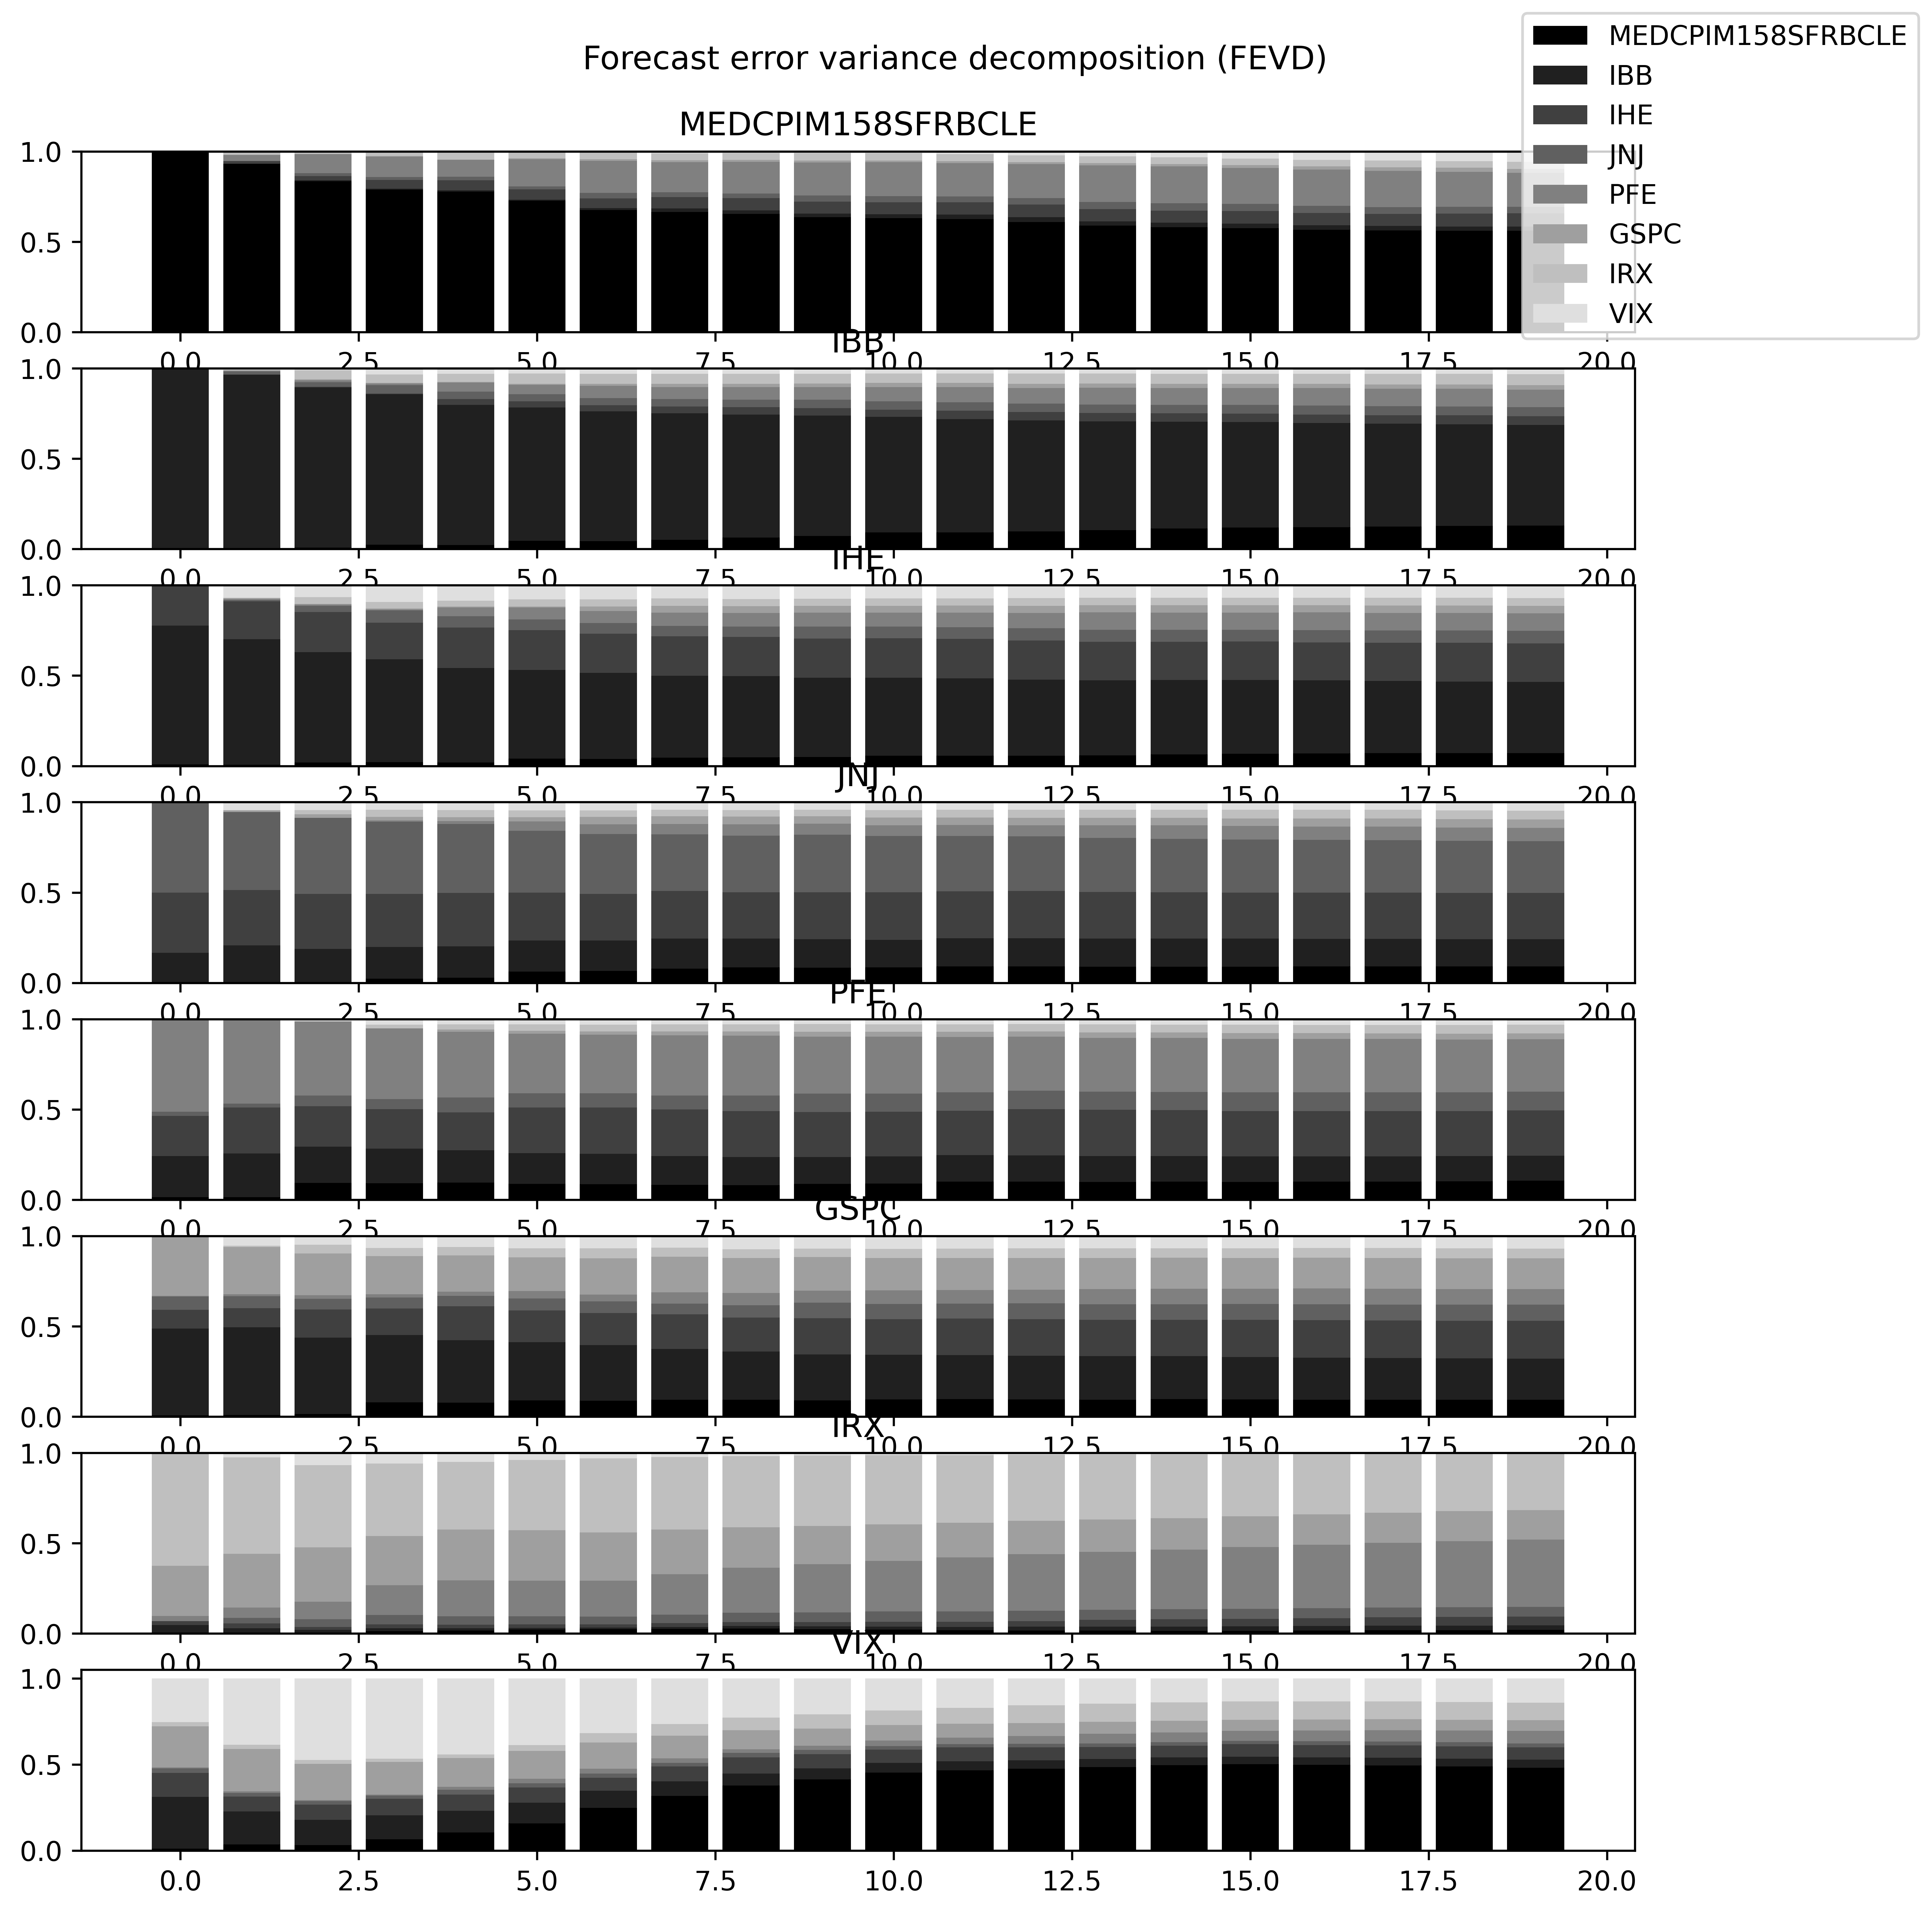

In [90]:
fevd = result.fevd(20)
fig = fevd.plot()
fig.set_dpi(600)
plt.show()

In [91]:
lag_order = result.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = ndata.values[-lag_order:]
forecast_input

6


array([[ 4.90705453, -6.53630734, -4.94368097, -7.06701787, -9.01382061,
        -4.15939994,  4.7249999 , 20.57999992],
       [ 4.91159508,  1.37920957,  0.22887281,  2.76663361,  2.87029764,
         4.28797795,  4.57000017, 18.54999924],
       [ 4.65568634,  1.35473137,  3.15139823,  4.21344369, -5.31405338,
         1.0457974 ,  4.86499977, 16.07999992],
       [ 4.35544719, -3.69366232, -6.02691512, -4.94548197, -2.00568272,
         1.26716676,  5.20300007, 15.64999962],
       [ 2.28363919,  0.03619836,  3.48254446,  5.54422385, -3.66988941,
         5.40826429,  5.14499998, 13.56999969],
       [ 4.02731764,  0.97309753,  1.968338  ,  3.33524432, -1.77073126,
         2.68253125,  5.26000023, 13.93000031]])

In [92]:
nobs = 20
fc = result.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=data.index[-nobs:], columns=ndata.columns + '_2d')
df_forecast

,MEDCPIM158SFRBCLE_2d,IBB_2d,IHE_2d,JNJ_2d,PFE_2d,GSPC_2d,IRX_2d,VIX_2d
Date,,,,,,,,
2022-01-01,1.077487,-4.260541,-4.047763,-2.909284,-4.637374,-7.083625,4.939167,26.746602
2022-02-01,1.017316,-4.952418,-1.417032,2.859636,4.151633,-1.071695,4.769213,28.149483
2022-03-01,1.658568,5.483972,0.650798,0.621987,2.079878,-2.822634,4.583481,24.307428
2022-04-01,0.914625,11.152455,7.854985,8.864665,-6.594470,7.747507,4.452943,19.616243
2022-05-01,1.035360,6.366996,0.347688,0.969193,-3.209105,1.391186,4.265120,15.467467
2022-06-01,0.464427,2.384117,0.469458,3.356406,-11.194967,2.641854,4.049615,17.991902
2022-07-01,0.921833,0.568422,-3.299999,2.905325,-5.647410,2.008307,3.748077,13.493621
2022-08-01,1.450061,4.088736,0.729806,-0.790075,-5.134642,0.955573,3.384310,15.860025
2022-09-01,1.032349,8.546551,3.356059,5.478004,-1.656394,8.488819,3.174468,9.401468


In [93]:
def invert_transformation(test, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = test.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (test[col].iloc[-1]-train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = test[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results = invert_transformation(test, df_forecast, second_diff=True)        
df_results.loc[:, ['MEDCPIM158SFRBCLE_forecast','IBB_forecast', 'IHE_forecast', 'JNJ_forecast', 'PFE_forecast', 'GSPC_forecast', 'IRX_forecast', 'VIX_forecast']]

,MEDCPIM158SFRBCLE_forecast,IBB_forecast,IHE_forecast,JNJ_forecast,PFE_forecast,GSPC_forecast,IRX_forecast,VIX_forecast
Date,,,,,,,,
2022-01-01,2.887052,-3.998950,-2.760223,2.184611,-9.819166,-7.441631,15.419168,38.196603
2022-02-01,2.764102,-13.923416,-8.905815,3.893614,-13.715967,-18.637487,30.347548,90.612689
2022-03-01,4.299720,-18.363909,-14.400610,6.224604,-15.532891,-32.655978,49.859409,167.336204
2022-04-01,6.749963,-11.651947,-12.040420,17.420259,-23.944284,-38.926962,73.824213,263.675961
2022-05-01,10.235565,1.427010,-9.332542,29.585106,-35.564781,-43.806760,102.054137,375.483187
2022-06-01,14.185595,16.890084,-6.155206,45.106361,-58.380246,-46.044704,134.333677,505.282313
2022-07-01,19.057458,32.921581,-6.277868,63.532940,-86.843120,-46.274341,170.361293,648.575061
2022-08-01,25.379381,53.041815,-5.670724,81.169445,-120.440636,-45.548405,209.773220,807.727833
2022-09-01,32.733653,81.708598,-1.707521,104.283954,-155.694546,-36.333650,252.359614,976.282075


In [114]:
ndata.columns

Index(['MEDCPIM158SFRBCLE', 'IBB', 'IHE', 'JNJ', 'PFE', 'GSPC', 'IRX', 'VIX'], dtype='object')

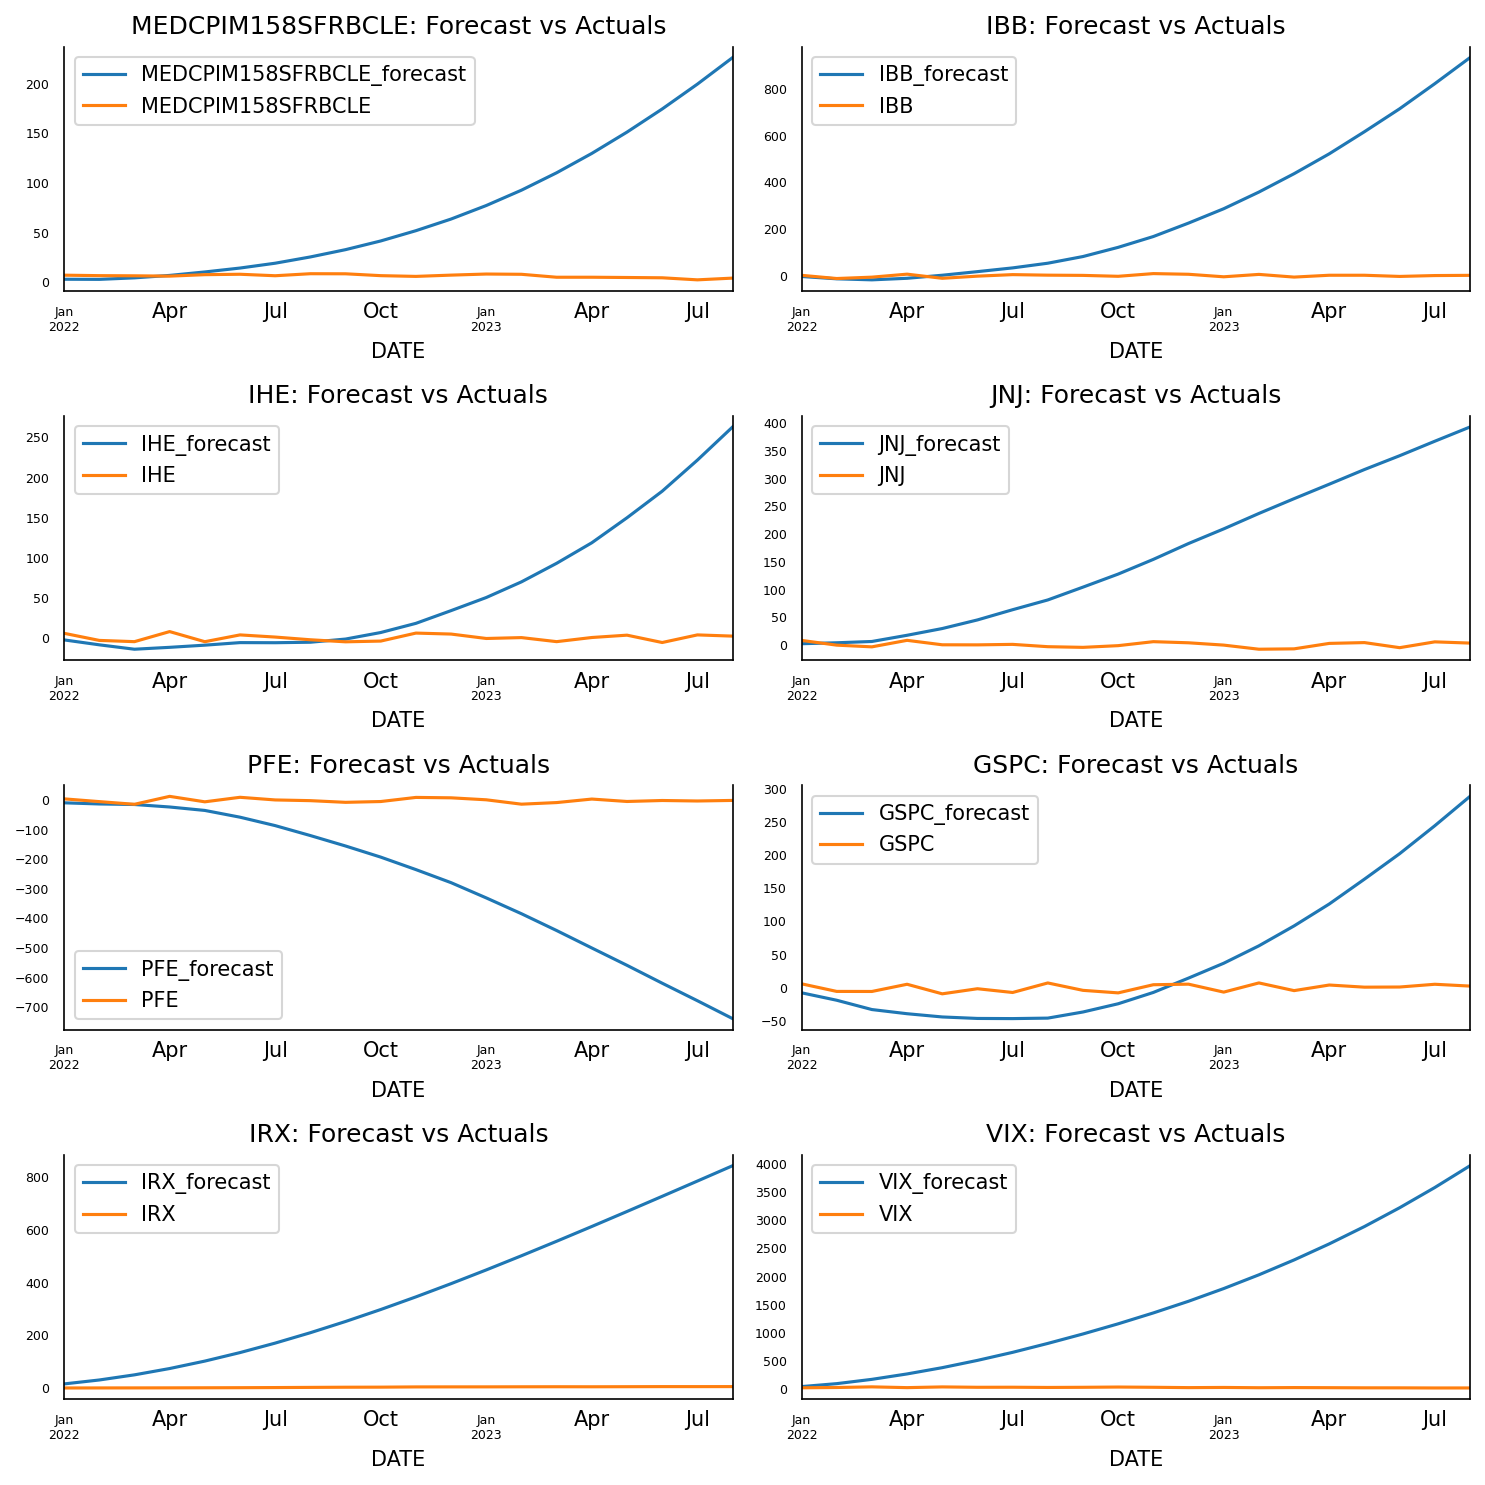

In [120]:
nobs = 20
columns = ['MEDCPIM158SFRBCLE', 'IBB', 'IHE', 'JNJ', 'PFE', 'GSPC', 'IRX', 'VIX']
fig, axes = plt.subplots(nrows=int(len(columns) / 2), ncols=2, dpi=150, figsize=(10, 10))

for i, col in enumerate(columns):
    ax = axes.flatten()[i]
    
    # Convert the index of the test DataFrame to a DatetimeIndex
    test.index = pd.to_datetime(test.index)
    
    df_results.index = pd.to_datetime(df_results.index)
    df_results[col + '_forecast'].plot(legend=True, ax=ax).autoscale(axis='x', tight=True)
    test[col][-nobs:].plot(legend=True, ax=ax)
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()
plt.show()
